**Izris pogostosti imen v casovnem obdobju** <br> Ker smo nazadnje z lazjimi imenskimi popravki dobili cudne rezultate sem s chatgpt-jem zgeneriral vecji set imenskih popravkov.

importi:

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict, Counter
import json
from pathlib import Path
import numpy as np

Nalozimo clanke

In [2]:
with open('combined_finish.json', 'r', encoding='utf-8') as f:
    clanki = json.load(f)

Nalagamo slovar s popravki

In [3]:
def nalozi_popravke(pot="imenski_popravki.json"):
    if Path(pot).exists():
        with open(pot, "r", encoding="utf-8") as f:
            return json.load(f)
    return {}

In [4]:
IMENSKI_POPRAVKI=nalozi_popravke()

funkcija ki nam popravi ime

In [5]:
def popravi_ime(ime):
    popravljeno=IMENSKI_POPRAVKI.get(ime, ime)
    if(popravljeno==''):
        return ime
    return popravljeno


funkcija ki za podano osebo/osebe izracuna prikaze linearni graf njene omenjensti.

In [6]:

def drsece_povprecje(vrednosti, okno=3):
    """Glajenje vrednosti z drsečim povprečjem."""
    if len(vrednosti) < okno:
        return vrednosti  # Ni dovolj točk
    return np.convolve(vrednosti, np.ones(okno)/okno, mode='same')

def graphPrepoznavnosti(imena, datum_od, datum_do, popravek=True, poenostavi=False, okno=3):
    if isinstance(imena, str):
        imena = [imena]  # Pretvori v seznam, če podan niz

    datum_od = datetime.strptime(datum_od, "%d. %m. %Y")
    datum_do = datetime.strptime(datum_do, "%d. %m. %Y")

    vse_pojavitve = {ime: defaultdict(int) for ime in imena}

    for clanek in clanki:
        try:
            datum_clanka = datetime.strptime(clanek["date"].strip(), "%d. %m. %Y %H.%M")
        except (KeyError, ValueError):
            continue

        if not (datum_od <= datum_clanka <= datum_do):
            continue

        persons = clanek.get("persons", {})

        for izvirno_ime in imena:
            if popravek:
                for person_ime, stevilo in persons.items():
                    norm_ime = popravi_ime(person_ime)
                    if norm_ime == izvirno_ime:
                        vse_pojavitve[izvirno_ime][datum_clanka.date()] += stevilo
            else:
                if izvirno_ime in persons:
                    vse_pojavitve[izvirno_ime][datum_clanka.date()] += persons[izvirno_ime]

    if all(not vrednosti for vrednosti in vse_pojavitve.values()):
        print("Za nobeno osebo ni pojavitev v danem obdobju.")
        return

    plt.figure(figsize=(12, 6))

    for ime, pojavitve_po_dnevih in vse_pojavitve.items():
        if not pojavitve_po_dnevih:
            continue

        datumi = sorted(pojavitve_po_dnevih)
        pojavitve = [pojavitve_po_dnevih[datum] for datum in datumi]

        if poenostavi:
            pojavitve = drsece_povprecje(pojavitve, okno)

        plt.plot(datumi, pojavitve, linestyle='-', label=ime)

    plt.title(f"Pojavitve oseb od {datum_od.date()} do {datum_do.date()}")
    plt.xlabel("Datum")
    plt.ylabel("Število pojavitev")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

**ZAKAJ NORMALIZACIJA** <BR>
Kot lep prikaz zakaj potrebujemo imena normalizirati sta spodnja grafa:

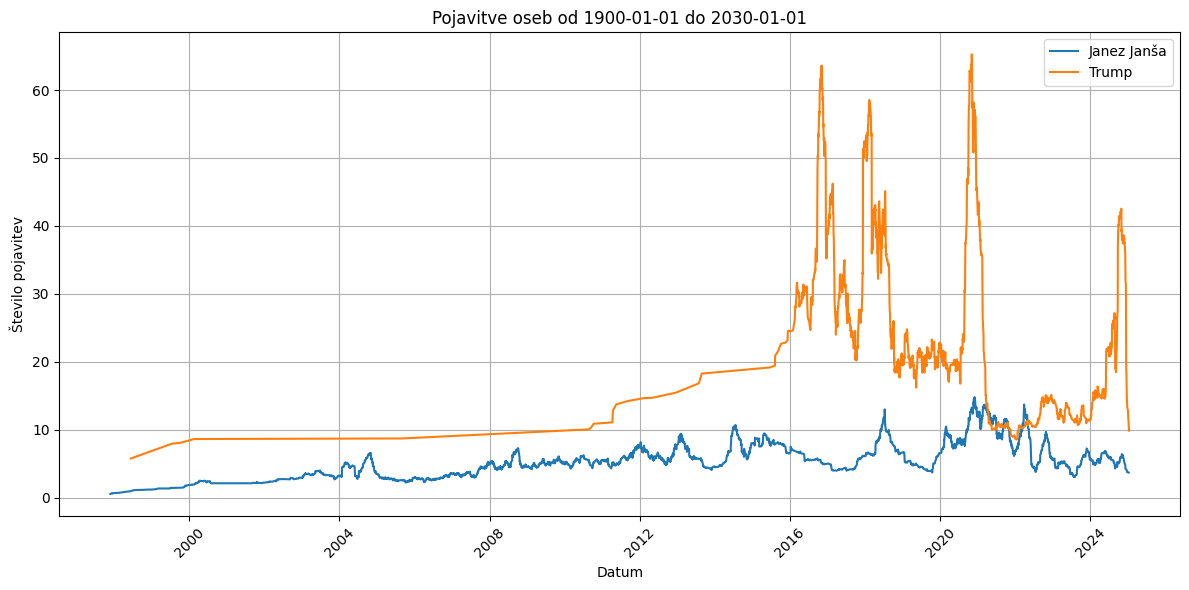

In [7]:
graphPrepoznavnosti(["Janez Janša", "Trump"], "1. 1. 1900", "1. 1. 2030", popravek=False, poenostavi=True, okno=60)

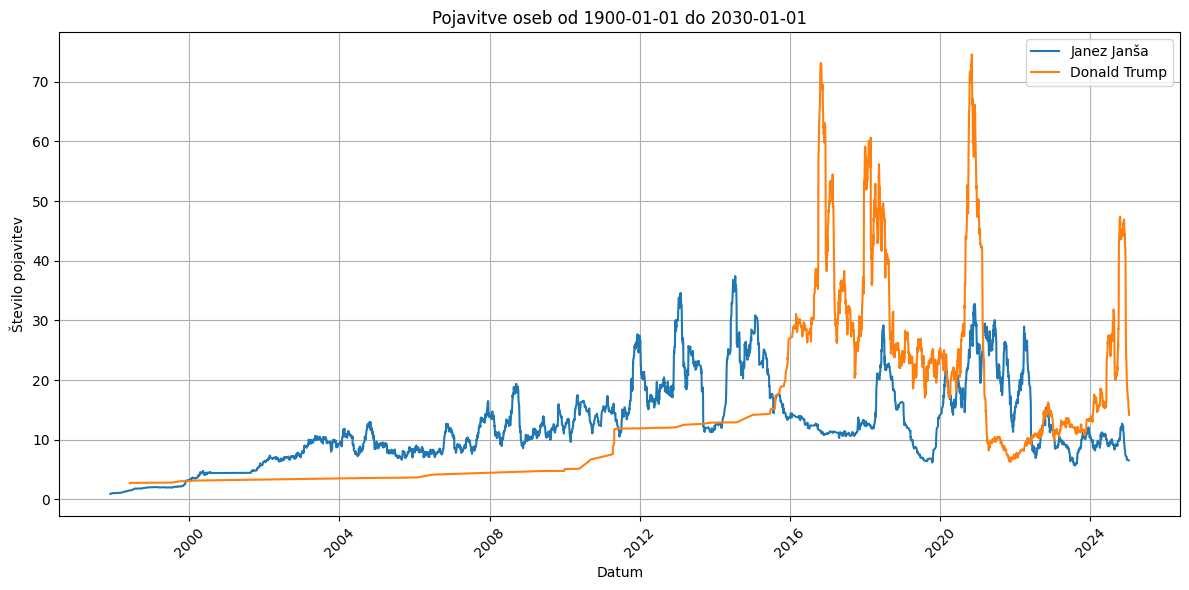

In [9]:
graphPrepoznavnosti(["Janez Janša", "Donald Trump"], "1. 1. 1900", "1. 1. 2030", popravek=True, poenostavi=True, okno=60)